# Porto Seguro’s Safe Driver Prediction
### Predict if a driver will file an insurance claim next year.

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import missingno

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.random_projection import SparseRandomProjection
from sklearn.manifold import TSNE
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

import category_encoders as ce

from numba import jit
import time
import gc

from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

pd.set_option('display.max_columns', 100)

## Read Data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Explore, Analyze, Preprocess

In [3]:
train.shape, test.shape

((595212, 59), (892816, 58))

In [4]:
train.drop_duplicates()
train.shape

(595212, 59)

No duplicates found! Phew!

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

A nice mix of binary and categorical features, integers and floats.

Missing values are denoted with -1

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,595212.0,743803.558435,429367.820429,7.000000,371991.500000,743547.500000,1.115549e+06,1.488027e+06
target,595212.0,0.036448,0.187401,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
ps_ind_01,595212.0,1.900378,1.983789,0.000000,0.000000,1.000000,3.000000e+00,7.000000e+00
ps_ind_02_cat,595212.0,1.358943,0.664594,-1.000000,1.000000,1.000000,2.000000e+00,4.000000e+00
ps_ind_03,595212.0,4.423318,2.699902,0.000000,2.000000,4.000000,6.000000e+00,1.100000e+01
ps_ind_04_cat,595212.0,0.416794,0.493311,-1.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
ps_ind_05_cat,595212.0,0.405188,1.350642,-1.000000,0.000000,0.000000,0.000000e+00,6.000000e+00
ps_ind_06_bin,595212.0,0.393742,0.488579,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
ps_ind_07_bin,595212.0,0.257033,0.436998,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
ps_ind_08_bin,595212.0,0.163921,0.370205,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00


## Meta-data

To facilitate the data management, we'll store meta-information about the variables in a DataFrame. This will be helpful when we want to select specific variables for analysis, visualization, modeling, ...

Concretely we will store:
- vtype: nominal, interval, ordinal, binary
- has_missing: 1 is has missing values, 0 otherwise

In [7]:
data = []
for f in train.columns:       
    # types
    if 'bin' in f or f == 'target':
        vtype = 'binary'
    elif 'cat' in f or f == 'id':
        vtype = 'nominal'
    elif train[f].dtype == float:
        vtype = 'interval'
    elif train[f].dtype == int:
        vtype = 'ordinal'
        
    if train[f].min() == -1:
        has_missing = 1
    else:
        has_missing = 0
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'vtype': vtype,
        'has_missing': has_missing
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'vtype', 'has_missing'])
meta.set_index('varname', inplace=True)

In [8]:
meta

,vtype,has_missing
varname,,
id,nominal,0
target,binary,0
ps_ind_01,ordinal,0
ps_ind_02_cat,nominal,1
ps_ind_03,ordinal,0
ps_ind_04_cat,nominal,1
ps_ind_05_cat,nominal,1
ps_ind_06_bin,binary,0
ps_ind_07_bin,binary,0


In [9]:
pd.DataFrame({'count' : meta.groupby(['vtype'])['vtype'].size()}).reset_index()

,vtype,count
0,binary,18
1,interval,10
2,nominal,15
3,ordinal,16


In [10]:
train[meta[meta.vtype == 'interval'].index].describe().T

,count,mean,std,min,25%,50%,75%,max
ps_reg_01,595212.0,0.610991,0.287643,0.000000,0.400000,0.700000,0.900000,0.900000
ps_reg_02,595212.0,0.439184,0.404264,0.000000,0.200000,0.300000,0.600000,1.800000
ps_reg_03,595212.0,0.551102,0.793506,-1.000000,0.525000,0.720677,1.000000,4.037945
ps_car_12,595212.0,0.379945,0.058327,-1.000000,0.316228,0.374166,0.400000,1.264911
ps_car_13,595212.0,0.813265,0.224588,0.250619,0.670867,0.765811,0.906190,3.720626
ps_car_14,595212.0,0.276256,0.357154,-1.000000,0.333167,0.368782,0.396485,0.636396
ps_car_15,595212.0,3.065899,0.731366,0.000000,2.828427,3.316625,3.605551,3.741657
ps_calc_01,595212.0,0.449756,0.287198,0.000000,0.200000,0.500000,0.700000,0.900000
ps_calc_02,595212.0,0.449589,0.286893,0.000000,0.200000,0.400000,0.700000,0.900000
ps_calc_03,595212.0,0.449849,0.287153,0.000000,0.200000,0.500000,0.700000,0.900000


In [11]:
train[meta[meta.vtype == 'ordinal'].index].describe().T

,count,mean,std,min,25%,50%,75%,max
ps_ind_01,595212.0,1.900378,1.983789,0.0,0.0,1.0,3.0,7.0
ps_ind_03,595212.0,4.423318,2.699902,0.0,2.0,4.0,6.0,11.0
ps_ind_14,595212.0,0.012451,0.127545,0.0,0.0,0.0,0.0,4.0
ps_ind_15,595212.0,7.299922,3.546042,0.0,5.0,7.0,10.0,13.0
ps_car_11,595212.0,2.346072,0.832548,-1.0,2.0,3.0,3.0,3.0
ps_calc_04,595212.0,2.372081,1.117219,0.0,2.0,2.0,3.0,5.0
ps_calc_05,595212.0,1.885886,1.134927,0.0,1.0,2.0,3.0,6.0
ps_calc_06,595212.0,7.689445,1.334312,0.0,7.0,8.0,9.0,10.0
ps_calc_07,595212.0,3.005823,1.414564,0.0,2.0,3.0,4.0,9.0
ps_calc_08,595212.0,9.225904,1.459672,2.0,8.0,9.0,10.0,12.0


In [12]:
train[meta[meta.vtype == 'binary'].index].describe().T

,count,mean,std,min,25%,50%,75%,max
target,595212.0,0.036448,0.187401,0.0,0.0,0.0,0.0,1.0
ps_ind_06_bin,595212.0,0.393742,0.488579,0.0,0.0,0.0,1.0,1.0
ps_ind_07_bin,595212.0,0.257033,0.436998,0.0,0.0,0.0,1.0,1.0
ps_ind_08_bin,595212.0,0.163921,0.370205,0.0,0.0,0.0,0.0,1.0
ps_ind_09_bin,595212.0,0.185304,0.388544,0.0,0.0,0.0,0.0,1.0
ps_ind_10_bin,595212.0,0.000373,0.019309,0.0,0.0,0.0,0.0,1.0
ps_ind_11_bin,595212.0,0.001692,0.041097,0.0,0.0,0.0,0.0,1.0
ps_ind_12_bin,595212.0,0.009439,0.096693,0.0,0.0,0.0,0.0,1.0
ps_ind_13_bin,595212.0,0.000948,0.030768,0.0,0.0,0.0,0.0,1.0
ps_ind_16_bin,595212.0,0.660823,0.473430,0.0,0.0,1.0,1.0,1.0


`target` mean is 0.036448, so there exists a big imbalance favoring 0.

In [13]:
(train.target == 1).sum(), train.shape[0]

(21694, 595212)

So, actually, only 21694 our of 595212 belong in the class 1.

## Class Imbalance - Undersampling

Our dataset is large enough for us to undersample and balance the prior class distribution.

In [14]:
def undersample(data, ratio=0.1):
    # Get the indices per target value
    idx_0 = train[data.target == 0].index
    idx_1 = train[data.target == 1].index

    # Get original number of records per target value
    nb_0 = len(data.loc[idx_0])
    nb_1 = len(data.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1 - ratio) * nb_1) / (nb_0 * ratio)
    undersampled_nb_0 = int(ratio * nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    data = data.loc[idx_list].reset_index(drop=True)
    
    return data

In [22]:
train_us = train
# train_us = undersample(train)

In [23]:
train_us.shape[0]

595212

In [24]:
(train.shape[0] - train_us.shape[0]) / train.shape[0]

0.0

In [25]:
(train_us.target == 1).sum(), train_us.shape[0]

(21694, 595212)

## Missing values

In [26]:
vars_with_missing = []

for f in train_us.columns:
    if meta.has_missing[f] == 1:
        missings = train_us[train_us[f] == -1][f].count()
        vars_with_missing.append(f)
        missings_perc = missings/train_us.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


- `ps_car_03_cat` and `ps_car_05_cat` have a large proportion of records with missing values. Remove these variables.
- For the other categorical variables with missing values, we can leave the missing value -1 as such.
-  Replace by the mean on the following:
    - `ps_reg_03` (continuous) has missing values for ~18% of all records.
    - `ps_car_11` (ordinal) has some records with missing values.
    - `ps_car_12` (continuous) has some records with missing value.
    - `ps_car_14` (continuous) has missing values for ~7% of all records.

Dropping the variables with too many missing values

In [27]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train_us.drop(vars_to_drop, inplace=True, axis=1)
test.drop(vars_to_drop, inplace=True, axis=1)

In [28]:
meta.drop(vars_to_drop, inplace=True)

In [29]:
id_test = test['id'].values
train_us.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
meta.drop('id', inplace=True)

Imputing with the mean or mode. Seems that these missing values provide information by being correlated with the correct label, so it's generally better to keep them.

In [30]:
# mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
# mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
# train_us['ps_reg_03'] = mean_imp.fit_transform(train_us[['ps_reg_03']]).ravel()
# train_us['ps_car_12'] = mean_imp.fit_transform(train_us[['ps_car_12']]).ravel()
# train_us['ps_car_14'] = mean_imp.fit_transform(train_us[['ps_car_14']]).ravel()
# train_us['ps_car_11'] = mode_imp.fit_transform(train_us[['ps_car_11']]).ravel()

In [31]:
v = meta[meta.vtype == 'nominal'].index

for f in v:
    dist_values = train_us[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


## Visualizations

In [32]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(13,13))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.3f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()

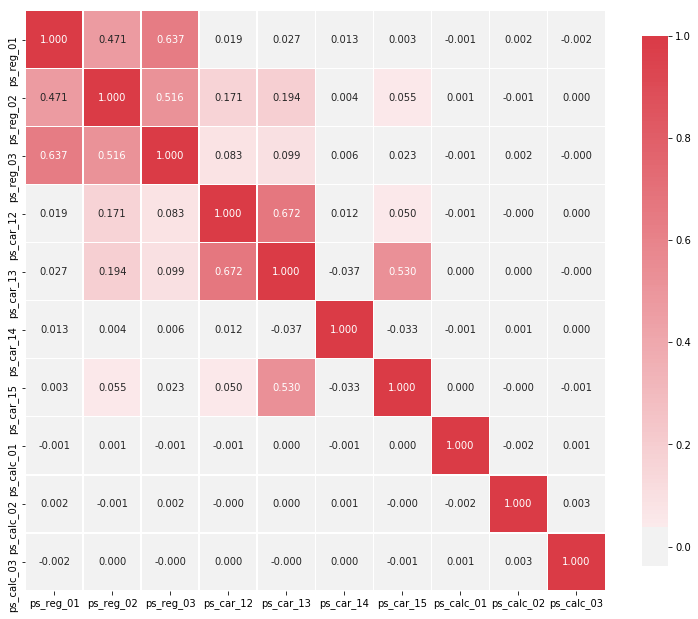

In [33]:
v = meta[meta.vtype == 'interval'].index
corr_heatmap(v)

In [34]:
S = train_us.sample(frac=0.2)

/home/nightmare/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


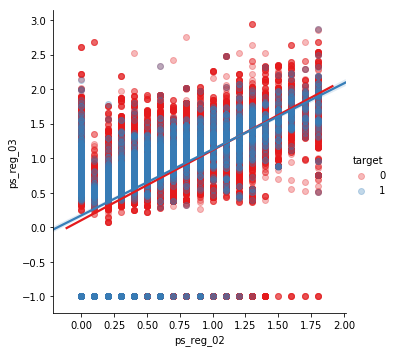

In [35]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=S, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

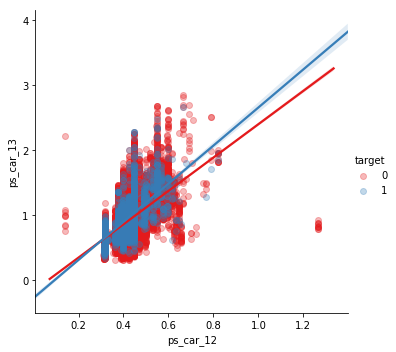

In [36]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=S, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

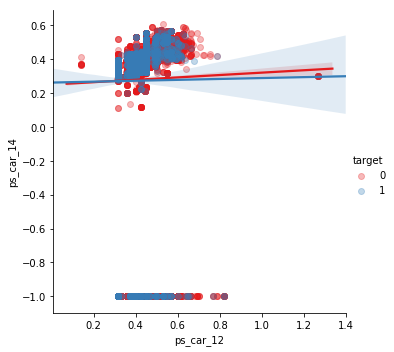

In [37]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=S, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

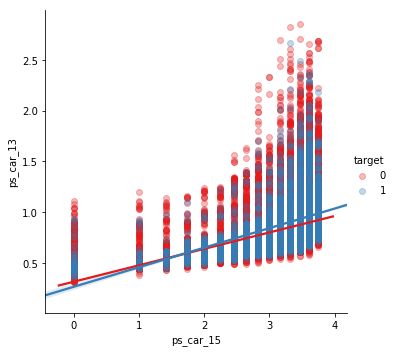

In [38]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=S, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

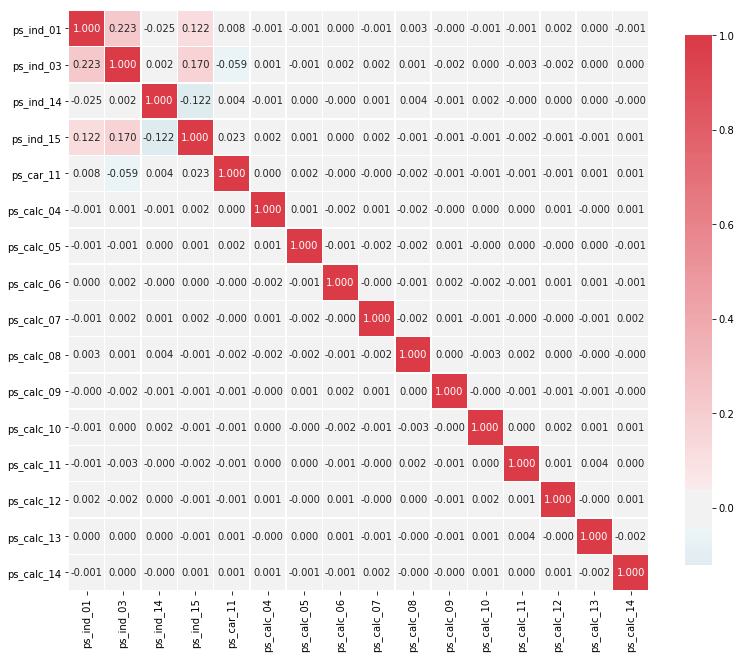

In [39]:
v = meta[meta.vtype == 'ordinal'].index
corr_heatmap(v)

In [40]:
S = train_us.sample(frac=0.05)
S.shape

(29761, 56)

<Figure size 432x288 with 0 Axes>

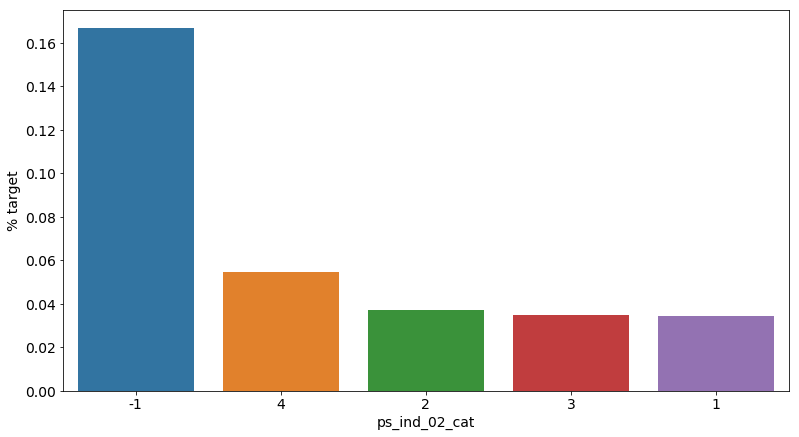

<Figure size 432x288 with 0 Axes>

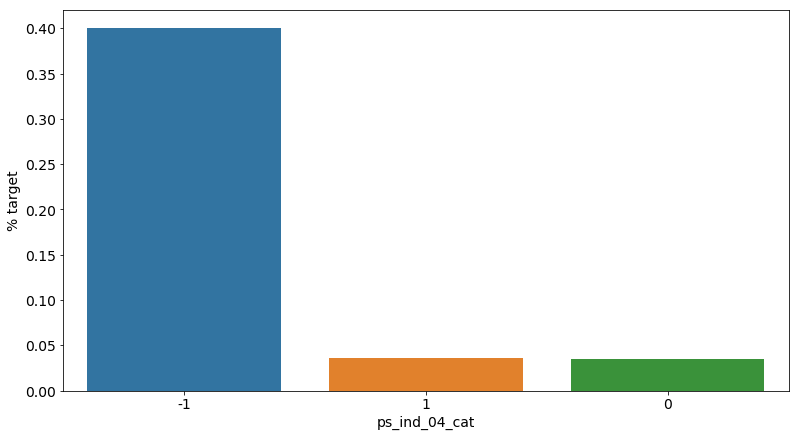

<Figure size 432x288 with 0 Axes>

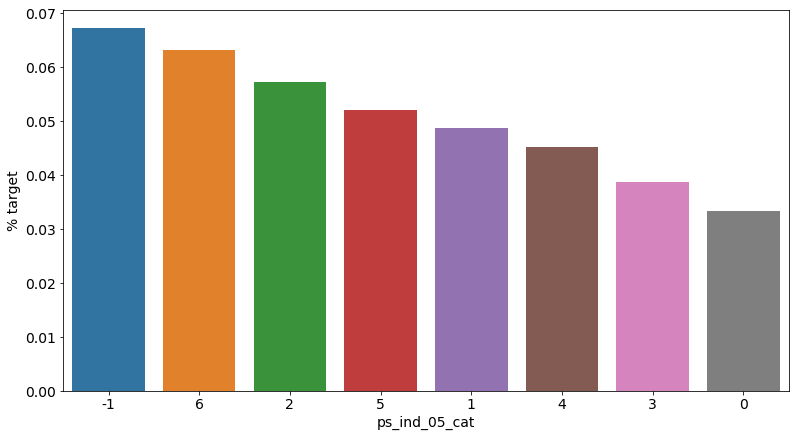

<Figure size 432x288 with 0 Axes>

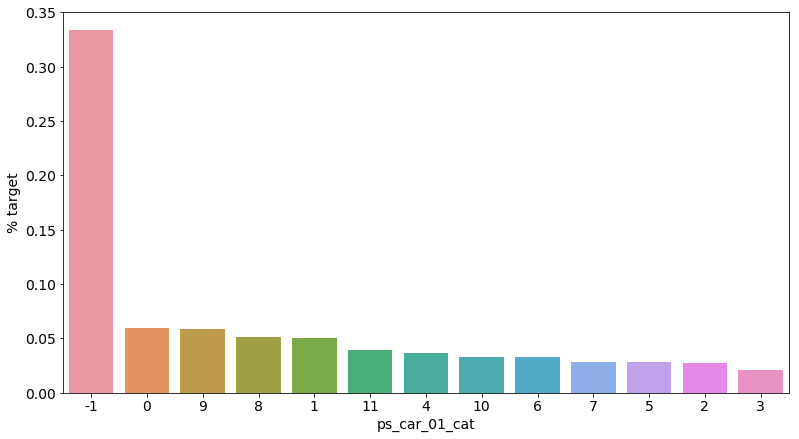

<Figure size 432x288 with 0 Axes>

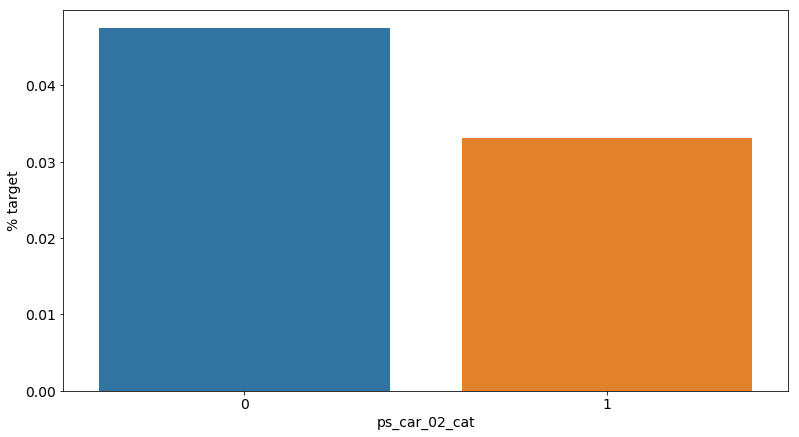

<Figure size 432x288 with 0 Axes>

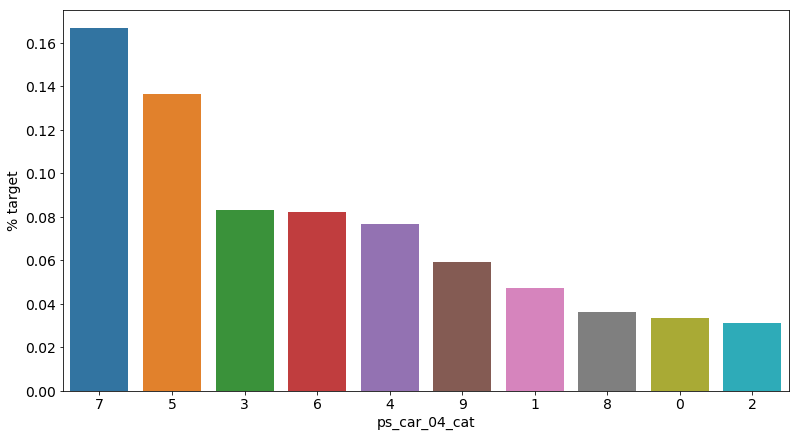

<Figure size 432x288 with 0 Axes>

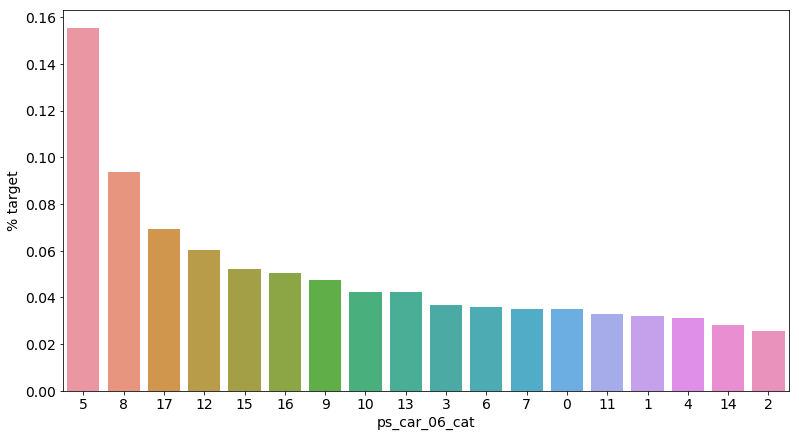

<Figure size 432x288 with 0 Axes>

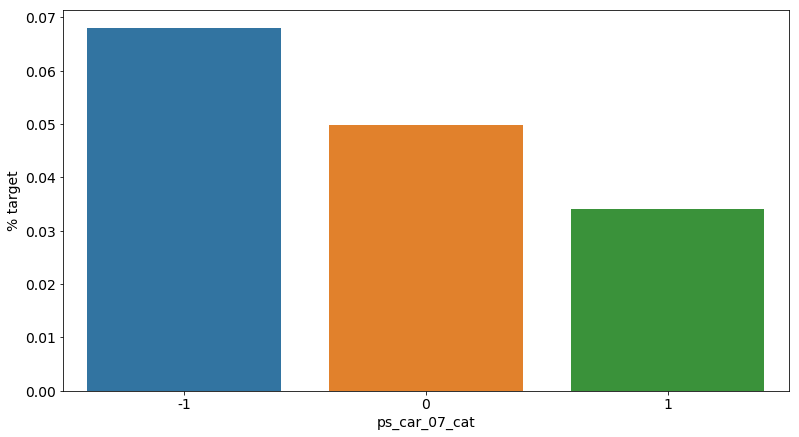

<Figure size 432x288 with 0 Axes>

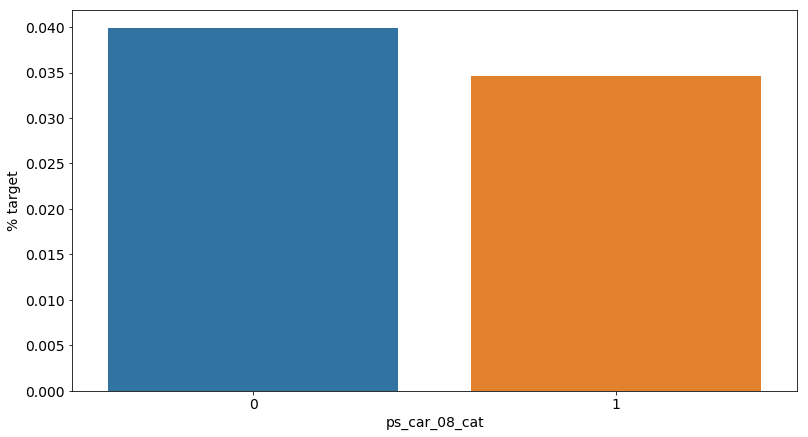

<Figure size 432x288 with 0 Axes>

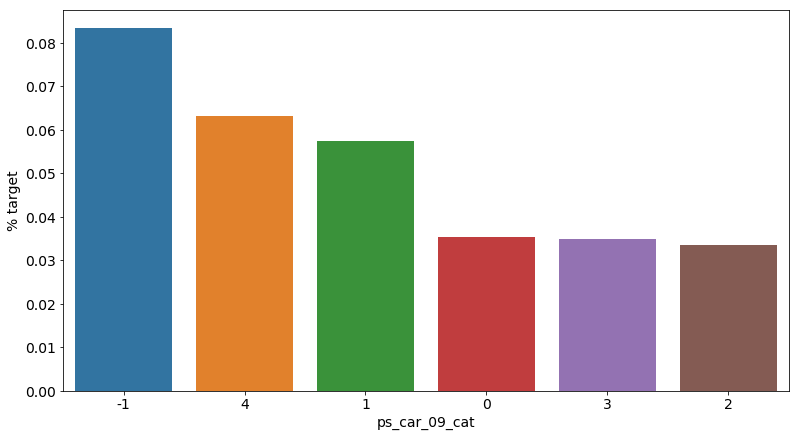

<Figure size 432x288 with 0 Axes>

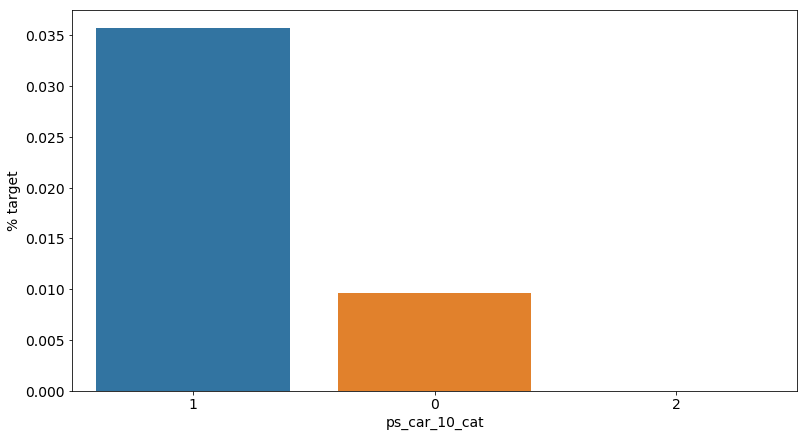

<Figure size 432x288 with 0 Axes>

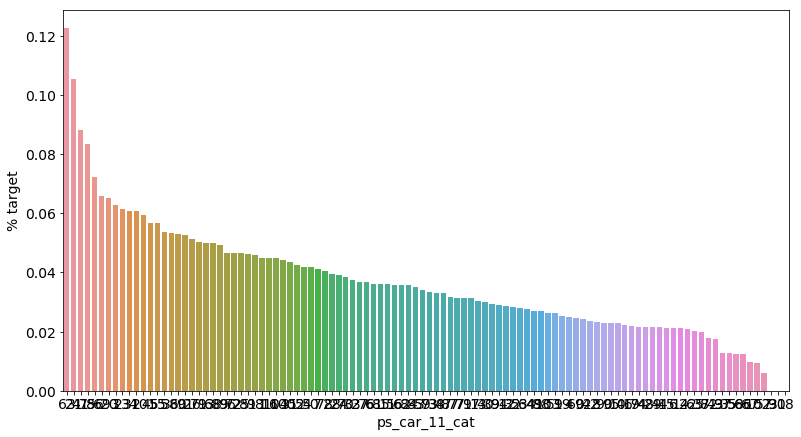

In [41]:
v = meta[meta.vtype == 'nominal'].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(13,7))
    # Calculate the percentage of target=1 per category value
    cat_perc = S[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=14)
    plt.xlabel(f, fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

In [42]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train_us.drop(['target'], axis=1))

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train_us.drop(['target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

6 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12']


### Get ready for the classifier

In [43]:
X_train = train_us.drop(['target'], axis=1)
y_train = train_us['target']
X_test = test

For tree based classifiers, target encoding and adding noise may not be the best idea.

In [44]:
# TE = ce.TargetEncoder(cols=list(meta[meta.vtype == 'nominal'].index), min_samples_leaf=100)
# X_train = TE.fit_transform(X_train, y_train)
# X_test = TE.transform(X_test)

In [45]:
# nom_shape = X_train[meta[meta.vtype == 'nominal'].index].shape
# X_train[meta[meta.vtype == 'nominal'].index] *= 1 + np.random.normal(0, 0.3, nom_shape)

In [46]:
# nom_shape = X_test[meta[meta.vtype == 'nominal'].index].shape
# X_test[meta[meta.vtype == 'nominal'].index] *= 1 + np.random.normal(0, 0.3, nom_shape)

In [47]:
v = meta[(meta.vtype == 'interval')].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(X_train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the train data
print('Before creating interactions we have {} variables in train'.format(X_train.shape[1]))
X_train = pd.concat([X_train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(X_train.shape[1]))

Before creating interactions we have 55 variables in train
After creating interactions we have 110 variables in train


In [48]:
v = meta[(meta.vtype == 'interval')].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(X_test[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
# Concat the interaction variables to the test data
print('Before creating interactions we have {} variables in test'.format(X_test.shape[1]))
X_test = pd.concat([X_test, interactions], axis=1)
print('After creating interactions we have {} variables in test'.format(X_test.shape[1]))

Before creating interactions we have 55 variables in test
After creating interactions we have 110 variables in test


In [49]:
selector = VarianceThreshold(threshold=.008)
selector.fit(X_train)

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v1 = X_train.columns[f(selector.get_support())]
v2 = X_test.columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v1)))
print('These variables are {}'.format(list(v2)))

5 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_12^2']


In [55]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=20, max_depth=7, min_samples_leaf=5, max_features=0.4, random_state=0)
gb.fit(X_train, y_train)
features = X_train.columns.values

print("----- Training Done -----")

----- Training Done -----


In [56]:
imp_std = np.std([gb.feature_importances_ for estim in gb.estimators_], axis=0)
imp_std

array([0.00000000e+00, 0.00000000e+00, 1.38777878e-17, 8.67361738e-19,
       0.00000000e+00, 0.00000000e+00, 6.93889390e-18, 1.73472348e-18,
       2.16840434e-19, 0.00000000e+00, 0.00000000e+00, 1.08420217e-19,
       0.00000000e+00, 1.30104261e-18, 6.93889390e-18, 6.93889390e-18,
       0.00000000e+00, 5.42101086e-20, 4.33680869e-19, 0.00000000e+00,
       0.00000000e+00, 6.93889390e-18, 0.00000000e+00, 1.73472348e-18,
       1.73472348e-18, 0.00000000e+00, 0.00000000e+00, 8.67361738e-19,
       4.33680869e-19, 8.67361738e-19, 8.67361738e-19, 2.16840434e-19,
       1.38777878e-17, 5.20417043e-18, 2.16840434e-19, 6.50521303e-19,
       2.16840434e-19, 0.00000000e+00, 4.33680869e-19, 4.33680869e-19,
       4.33680869e-19, 8.67361738e-19, 4.33680869e-19, 4.33680869e-19,
       8.67361738e-19, 8.67361738e-19, 1.30104261e-18, 1.73472348e-18,
       0.00000000e+00, 6.77626358e-21, 5.42101086e-20, 0.00000000e+00,
       5.42101086e-20, 2.16840434e-19, 0.00000000e+00, 8.67361738e-19,
      

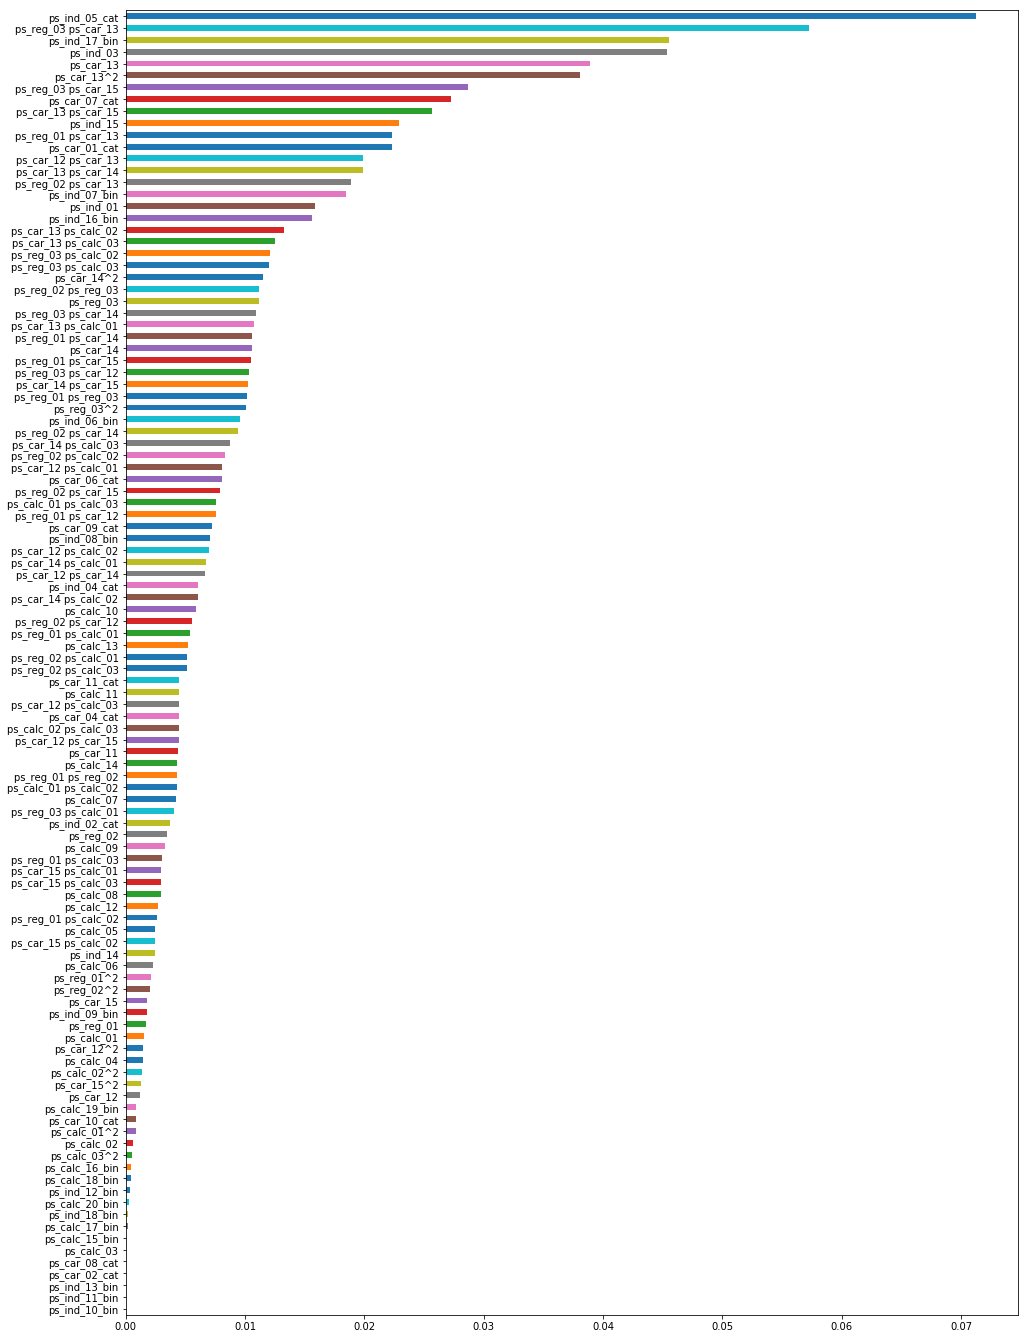

In [57]:
s_imp = sorted(range(len(gb.feature_importances_)), key=lambda k: gb.feature_importances_[k])
pd.Series(sorted(gb.feature_importances_), index=X_train.columns[s_imp]).plot(kind='barh', figsize=(16,24), xerr=imp_std[s_imp])

In [62]:
to_drop = list(X_train.columns[s_imp[:20]])
to_drop

['ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_13_bin',
 'ps_car_02_cat',
 'ps_car_08_cat',
 'ps_calc_03',
 'ps_calc_15_bin',
 'ps_calc_17_bin',
 'ps_ind_18_bin',
 'ps_calc_20_bin',
 'ps_ind_12_bin',
 'ps_calc_18_bin',
 'ps_calc_16_bin',
 'ps_calc_03^2',
 'ps_calc_02',
 'ps_calc_01^2',
 'ps_car_10_cat',
 'ps_calc_19_bin',
 'ps_car_12',
 'ps_car_15^2']

In [64]:
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

In [51]:
from sklearn.manifold import TSNE

n_sne = 7000

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 79045 samples in 1.580s...
[t-SNE] Computed neighbors for 79045 samples in 1566.737s...
[t-SNE] Computed conditional probabilities for sample 1000 / 79045
[t-SNE] Computed conditional probabilities for sample 2000 / 79045
[t-SNE] Computed conditional probabilities for sample 3000 / 79045
[t-SNE] Computed conditional probabilities for sample 4000 / 79045
[t-SNE] Computed conditional probabilities for sample 5000 / 79045
[t-SNE] Computed conditional probabilities for sample 6000 / 79045
[t-SNE] Computed conditional probabilities for sample 7000 / 79045
[t-SNE] Computed conditional probabilities for sample 8000 / 79045
[t-SNE] Computed conditional probabilities for sample 9000 / 79045
[t-SNE] Computed conditional probabilities for sample 10000 / 79045
[t-SNE] Computed conditional probabilities for sample 11000 / 79045
[t-SNE] Computed conditional probabilities for sample 12000 / 79045
[t-SNE] Computed conditional probabilities for

<function matplotlib.pyplot.show(*args, **kw)>

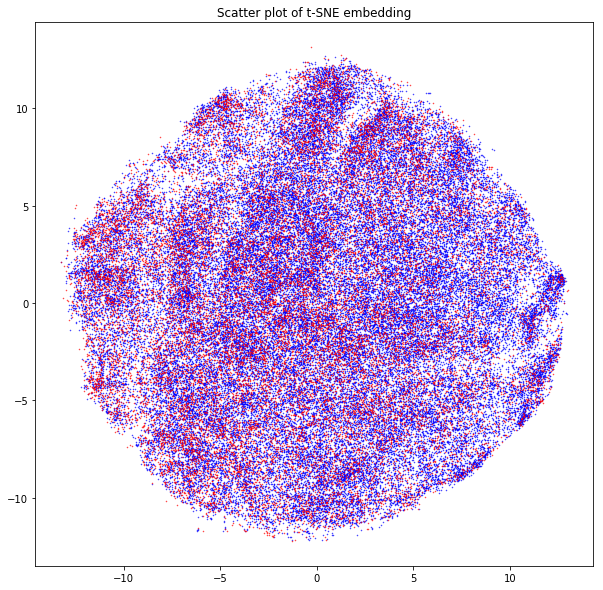

In [58]:
plt.figure(figsize=(10, 10))
for color, i, target_name in zip(['b', 'r'], [0, 1], np.unique(y_train)):
    plt.scatter(tsne_results[y_train == i, 0], tsne_results[y_train == i, 1], color=color, s=1,
                alpha=.8, marker='.')
plt.title('Scatter plot of t-SNE embedding')
plt.show

The task is a hard one. Even for different perplexities and iterations of t-SNE, the manifolds at dancing together.

## Functions

### Gini

In [50]:
# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

## Stacked Model

What seemed to work better is a stacked model of many gradient boosting classifiers as base models to reduce the variance and a simple logistic regression model on top. Having many categorial values helps this type of model.

In [65]:
class Stacker(object):
    def __init__(self, top_model, base_models):
        self.top_model = top_model
        self.base_models = base_models
        self.n_splits=3

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]

                print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.top_model, S_train, y, cv=3, scoring='roc_auc')
        print("Stacker score: %.5f" % (results.mean()))

        self.top_model.fit(S_train, y)
        res = self.top_model.predict_proba(S_test)[:,1]
        return res

In [ ]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 651
lgb_params['max_bin'] = 11
lgb_params['subsample'] = 0.78
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.82   
lgb_params['min_child_samples'] = 520


# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.05
xgb_params['n_estimators'] = 500
xgb_params['max_depth'] = 5
xgb_params['subsample'] = 0.91
xgb_params['colsample_bytree'] = 0.92  
xgb_params['min_child_weight'] = 12


# CatBoost params
cat_params = {}
cat_params['iterations'] = 933
cat_params['depth'] = 9
cat_params['rsm'] = 0.95
cat_params['learning_rate'] = 0.03
cat_params['l2_leaf_reg'] = 3.7  
cat_params['border_count'] = 8
cat_params['leaf_estimation_iterations'] = 4


lgb_model = LGBMClassifier(**lgb_params)
        
xgb_model = XGBClassifier(**xgb_params)

cat_model = CatBoostClassifier(**cat_params)

log_model = LogisticRegression()

        
stack = Stacker(top_model = log_model,
        base_models = (lgb_model, xgb_model, cat_model))        
        
y_pred = stack.fit_predict(X_train, y_train, X_test)        



sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = y_pred
sub.to_csv('stacked_1.csv', index=False)

Fit LGBMClassifier fold 1
Fit LGBMClassifier fold 2
Fit LGBMClassifier fold 3
Fit XGBClassifier fold 1
